Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = ""
COLLABORATORS = ""

---

# Vaja 8: Rekonstrukcija 3D oblik
## Navodila
Pri rekonstrukciji 3D oblik želimo s pomočjo ene ali več 2D slik nekega objekta, zajetih iz različnih pogledov in/ali pod različnimi osvetlitvami, najti optimalno 3D obliko tega objekta tako, da bo 3D oblika čim bolje sovpadala z zajetimi 2D slikami. Eden od postopkov rekonstrukcije 3D oblik je **fotometrični stereo**, pri katerem izluščimo informacijo o obliki na podlagi senc na objektu. Sence ustvarimo z osvetlitvijo objekta iz različnih smeri (npr. $\mathbf{s}_1$, $\mathbf{s}_2$, $\mathbf{s}_3$), slike pa zajamemo iz enega pogleda ($\mathbf{v}$). Iz zajetih slik dobimo v vsaki točki slike $(x, y)$ oceno normale na površino $\mathbf{n}$, z integriranjem teh normal glede na neko izhodiščno točko dobimo rekonstrukcijo 3D oblike.

![Fotometrični stereo](images/RV_9_SLO_Fotostereo.png)

Če predpostavimo, da pri interakciji svetloba-površina pride le do difuznega odboja, potem lahko enostavno povežemo svetilnost slikovnega elementa z obliko površine. Uporabimo **Lambertov model difuzne površine**:
$$
	I(x, y) = \frac{kc}{\pi}\, \rho_i\, \cos \theta_i = \frac{kc}{\pi}\, \rho_i\, \mathbf{s} \circ \mathbf{n}\,,
$$
kjer je $k$ svetilnost vira, $c$ konstanta optičnega sistema, $\rho$ albedo oz. odbojnost površine. Če predpostavimo, da je $\frac{kc}{\pi} = 1$ potem dobimo za $j$-to svetilo ($j=1, \ldots, N$) enačbo za svetilnost slikovnega elementa v obliki $I_j(x,y) = \rho_i\, \cos\theta_i = \rho_i\, \mathbf{s}_j \circ \mathbf{n}$. Za oceno normale na površino $\mathbf{n}$ v točki slike $(x, y)$ potrebujemo vsaj tri svetila ($N=3$) iz različnih smeri ($\mathbf{s}_1$, $\mathbf{s}_2$, $\mathbf{s}_3$), da lahko zapišemo minimalen sistem linearnih enačb.

![Sistem enačb](images/RV_9_SLO_Sistem_enacb.png)

Z gornjim postopkom dobimo oceno normale $\mathbf{n}$ na površino objekta v vsaki točki slike $(x,y)$. Ocena normale je bolj robustna, če uporabimo več osvetlitev objekta iz več med seboj različnih smeri $\mathbf{s}_j,\, N>3$. V katerem od $j$ pogledov so lahko nekateri slikovni elementi relativno temni, zato bo ocena normale v teh slikovnih elementih manj zanesljiva, kar rešimo z uteževanjem enačb s svetlostjo $I_j = I_j(x,y)$ iz slik posameznega pogleda $\mathbf{s}_j$.

![Sistem enačb](images/RV_9_SLO_Sistem_enacb2.png)

Sistem enačb za določanje normale na površino rešimo za vsako točko $(x,y)$ in tako dobimo sliko normal na površino $\mathbf{n}(x,y)$, s pomočjo katere lahko na več načinov rekonstruiramo 3D obliko objekta kot sliko povšine oz. globine $z(x,y)$. Sliko površine $z(x,y)$ naprimer lahko določimo z analizo odvodov na površino $\partial z / \partial x$ in $\partial z / \partial y$, ki morata biti v vsaki točki $(x, y)$ pravokotna na normalo $\mathbf{n}$. Iz pripadajočih enačb za sliko velikosti $XY$ zgradimo linearen sistem $\mathbf{M}\mathbf{z} = \mathbf{p}$, katerega rešitev je slika površine $z(x,y)$. Matrika $\mathbf{M}$ ima dimenzije $(2XY \times XY)$, vektor $\mathbf{p}$ pa $(2XY \times 1)$. Matrika $\mathbf{M}$ je velika, a redka matrika (večina vrednosti je enaka 0), zato za manjšo obremenitev delovnega spomina uporabimo knjižnico `scipy.sparse` za definicijo redke matrike s funkcijo  `csc_matrix()`, vrednosti pa v matriko vnašamo posamezno z naslavljanjem vrstic in stolpcev. Rešitev sistema dobimo s funkcijo `lsqr()` v knjižnici `scipy.sparse.linalg`.

![Rešitev sistema](images/RV_9_SLO_Resitev_sistema.png)

![Rekonstrukcija površine](images/RV_9_SLO_Rekonstrukcija.png)

## Naloge
**Gradivo** za vajo v mapi `data` vsebuje datoteko `lights.txt`, v kateri so podane smeri svetil glede na objekt, slike objekta `owl.k.tif`, pri čemer je $k=0, \ldots, 11$, in pripadajočo masko objekta `owl.mask.tif`. 

1. Napišite funkcijo za branje tekstovne datoteke s smermi svetil: 
```python
    def readTxt( iFileName ):
        return oLightDir
```
kjer parameter `iFileName` predstavlja ime datoteke za branje (`'lights.txt'`). Datoteko odprete in zaprete s funkcijama `open()` in `close()`, posamezne vrstice pa preberete s funkcijo `readline()`. Za pretvorbo števil iz besedila v numerični tip lahko uporabite funkciji `split()` in `float()`. Funkcija vrne matriko `oLightDir`, ki bo imela za dano datoteko `'lights.txt'` dimenzije $12 \times 3$.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import rvlib

def readTxt(iFileName):
    # nalozi smeri svetil
    oLightsDir = np.array([])
    with open(iFileName, "r") as f:
        while True:
            line = f.readline()
            if not line: 
                break
            numbers = [float(x) for x in line.split()]
            numbers = np.array(numbers).reshape((1,3))
            if oLightsDir.size == 0:
                oLightsDir = numbers
            else:
                oLightsDir = np.vstack((oLightsDir,np.array(numbers)))
        return oLightsDir

In [3]:
# Test funkcije
S = readTxt("./data/lights.txt")
# Preverimo, da je spremenljivka S pravih dimenzij (12, 3)
print(S.shape)#imamo dvanajst svetil, vsako določeno s tremi koordinatami
print(S)#koordinate kamer

(12, 3)
[[ 0.403259   0.480808   0.778592 ]
 [ 0.0982272  0.163712   0.981606 ]
 [-0.0654826  0.180077   0.98147  ]
 [-0.127999   0.431998   0.892745 ]
 [-0.328606   0.485085   0.810377 ]
 [-0.110339   0.53593    0.837021 ]
 [ 0.239071   0.41439    0.878138 ]
 [ 0.0642302  0.417497   0.906406 ]
 [ 0.12931    0.339438   0.931698 ]
 [ 0.0323953  0.340151   0.939813 ]
 [ 0.0985318  0.0492659  0.993914 ]
 [-0.16119    0.354617   0.921013 ]]


2. Ustvarite spremenljivko tipa `list` in zaporedoma od `k = 0,...,11` naložite vse dane barvne slike `owl.k.tif`. Sliki z indeksom `k` pripada smer svetila v matriki `oLightDir` z indeksom `[k, :]`. V spremenljivko `numpy.array` naložite tudi sliko maske `owl.mask.tif`.
  * Izračunajte povprečno barvno sliko, npr. `iMeanImage`.
  * Pretvorite vse slike v sivinske slike in jih shranite v spremenljivko tipa `numpy.array`, npr. `iImages` z dimenzijami $Y \times X \times 12$, kjer sta $X, Y$ dimenziji 2D slike.
  * Pretvorite sliko maske v sivinsko sliko, npr. `iMask`.

In [4]:
iImages = []
iMask = rvlib.colorToGray(rvlib.loadImage("./data/owl.mask.tif"))
for i in range(12):
    iImages.append(rvlib.loadImage("./data/owl.%d.tif" % i))

3. Napišite funkcijo, ki izračuna normale na površino objekta $\mathbf{n}$ iz treh slik objekta: 
```python
    def computeNormals( iImages, iMask, iLightDir ):
        return oNormals
```
kjer je `iImages` matrika dimezij $Y \times X \times 3$ ($X, Y$ sta dimenziji 2D slike), `iMask` je maska objekta in `iLightDir` matrika $3 \times 3$ s smermi osvetlitve, ki ustrezajo slikam v matriki `iImages`. Funkcija vrne 3D matriko nenormaliziranih normal $\tilde{\mathbf{n}}$ dimenzij $Y \times X \times 3$ v spremenljivki `oNormals`. Preizkusite delovanje funkcije s poljubnimi tremi vhodnimi slikami ($N = 3$), pri tem pa pozorno izberite vhodne slike glede na pripadajoče smeri osvetlitve $\mathbf{s}_j$. 

  Prikažite povprečno barvno sliko `iMeanImage` in izrišite normale v obliki vektorskega polja s funkcijo `quiver()` v knjižnici `matplotlib.pyplot`. Preverite ali so smeri normal smiselne glede na dano sliko 3D oblike.

In [5]:
def computeNormals(iImages, iMask, iLightDir):
    """Izracun normal na povrsino objekta iz treh ali vec slik"""
    if iLightDir.shape[0] != 3:
        raise NotImplementedError('Funkcija še ne podpira rekonstrukcije v ' + \
                                'primeru da je število slik različno od 3.')  
      
    Sinv = np.linalg.inv(iLightDir.transpose())    
    
    shapeImages = iImages.shape
    iImages = iImages.reshape((iImages.shape[0]*iImages.shape[1],iImages.shape[2]))
    
    oNormals = np.dot(iImages, Sinv)    
    oNormals[iMask.flatten() == 0] = 0
    oNormals = oNormals.reshape((shapeImages[0],shapeImages[1],3))
    return oNormals

<IPython.core.display.Javascript object>


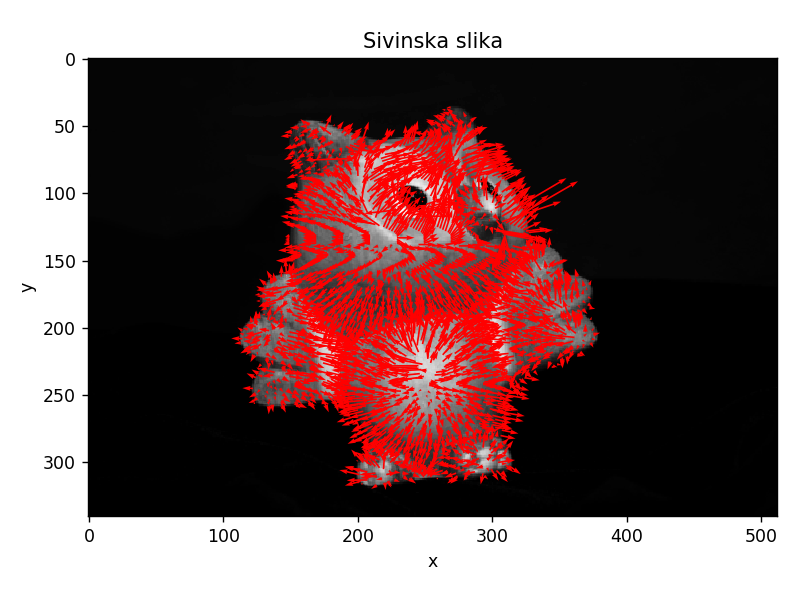

In [6]:
# pretvori vse slike v sivinske slike
iImagesG = [rvlib.colorToGray(iImages[i]) for i in range(len(iImages))]
# izberi tri nakljucne vrednosti med 0 in 11
while True:
    idx = np.unique(np.round(sp.rand(3) * (len(iImages)-1)))
    if idx.size == 3:
        idx = idx.astype('int32')
        break
idx = [1, 5, 11]
# pripravi vhodne spremenljivke
iImagesG_in = np.dstack([iImagesG[idx[i]] for i in range(len(idx))])
iLightsDir_in = S[idx,:]
# klici funkcijo
oNormals = computeNormals(iImagesG_in.astype('float'), iMask, iLightsDir_in)
# prikazi normale
my, mx = np.where(iMask > 0)
my = my[::20]
mx = mx[::20]
%matplotlib notebook
rvlib.showImage(np.mean(iImagesG_in, axis=2), 'Sivinska slika')
gx, gy = np.meshgrid(range(iImagesG_in.shape[1]), range(iImagesG_in.shape[0]), indexing='xy')
plt.quiver(gx[my, mx], gy[my, mx],
           oNormals[my, mx, 0],
           oNormals[my, mx, 1], color='r', scale=3000)

4. Napišite funkcijo, ki izračuna albedo oz. odbojnost $\rho$ površine objekta s pomočjo slike nenormaliziranih normal $\tilde{\mathbf{n}}$: 
```python
    def computeAlbedo( iNormals, iMask ):
        return oAlbedo
```
kjer je `iNormals` matrika z dimezijami $Y \times X \times 3$ ($X, Y$ sta dimenziji 2D slike, vsaka normala $\tilde{\mathbf{n}}$ pa ima tri komponente), `iMask` je maska objekta z dimenzijami $Y \times X$. Funkcija vrne 2D matriko oz. sliko albeda $\rho$ z dimenzijami $Y \times X$ v spremenljivki `oAlbedo`. Zagotovite, da bodo vrednosti v `oAlbedo` na območju $[0, 1]$. 

  Preizkusite delovanje funkcije za sliko normal, ki ste jo izračunali pri prejšnji nalogi.

In [8]:
def computeAlbedo(iNormals, iMask):
    """Izracunaj albedo iz nenormaliziranih normal"""
    oAlbedo = np.sqrt(np.sum(iNormals**2.0, axis=2))
    oAlbedo[ iMask == 0 ] = 0
    oAlbedo = oAlbedo / np.max(oAlbedo)
    return oAlbedo

<IPython.core.display.Javascript object>


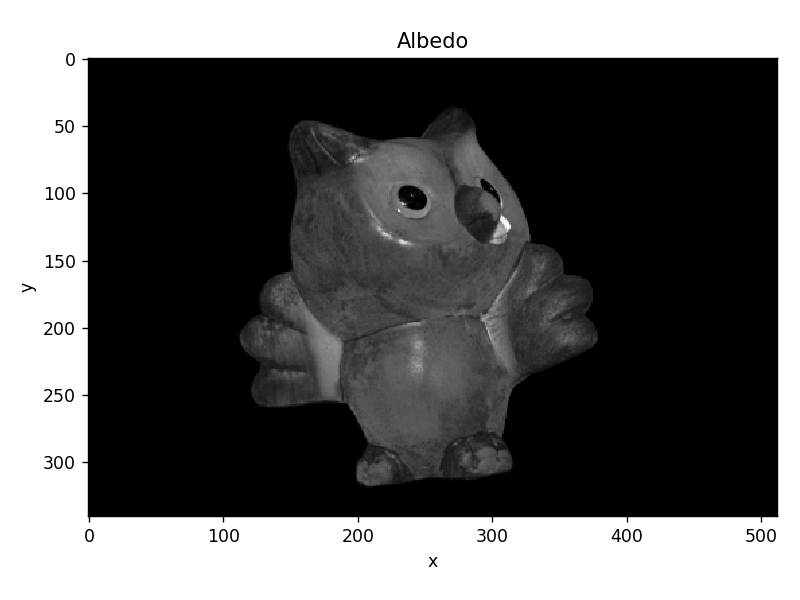

In [9]:
# test funkcije
# pretvori vse slike v sivinske slike 
oAlbedo = computeAlbedo(oNormals, iMask)
rvlib.showImage(oAlbedo, 'Albedo')

5. Napišite funkcijo, ki rekonstruira 3D obliko objekta oz. vsaki točki na objektu pripiše globino $z(x, y)$ z analizo odvodov na površino in reševanjem linearnega sistema enačb:
```python
    def computeDepthLinSys( iNormals, iMask ):
        return oDepth
```
kjer je `iNormals` matrika dimezij $Y \times X \times 3$, `iMask` je maska objekta z dimenzijami $Y \times X$. Poskrbite, da bodo normale `iNormals` podane v normalizirani obliki $\mathbf{n}$. Pri tej nalogi rešujete linearni sistem enačb $\mathbf{M} \mathbf{z} = \mathbf{p}$, pri čemer matriko $\mathbf{M}$ (dimenzije $2XY \times XY$) inicializirate z ukazom `csc_matrix()` v knjižnici `scipy.sparse`, elemente pa v matriko vpisujte posamezno pri ustreznih indeksih. Rešitev sistema enačb dobite s klicem funkcije `lsqr()` v knjižnici `scipy.sparse.linalg`. Vaša funkcija naj vrne 2D matriko z globino $z(x, y)$ dimenzij $Y \times X$ v spremenljivki `oDepth`. 

  Preizkusite delovanje funkcije s sliko normal, ki ste jo izračunali pri prvi nalogi. Prikažite rekonstruirano 3D površino s funkcijo `plot_surface()` v knjižnici `mpl_toolkits.mplot3d` in obarvajte površino glede na povprečno barvno sliko `iMeanImage`. 

In [10]:
def computeDepthLinSys(iNormals, iMask):
    """Izracunaj globino z resevanjem linearnega sistema enacb"""   
    from scipy.sparse import csc_matrix
    from scipy.sparse import linalg as splinalg    
    # doloci velikosti matrik
    my, mx = np.where(iMask > 0)    
    Ncols = my.size
    Nrows = 2*Ncols
    # inicializiraj spremenljivke
    rcData = []
    addToM = lambda x : rcData.append(x)
    v = np.zeros((Nrows, 1))
    index = np.zeros_like(iMask).astype('uint32')
    index[my, mx] = range(mx.size)
    # sprehodi se preko vseh elementov
    for i in range(mx.size):
        nx = iNormals[my[i], mx[i], 0]
        # obrni znak zaradi menjave koordinatnega sistema
        ny = -iNormals[my[i], mx[i], 1]
        nz = iNormals[my[i], mx[i], 2]
        # parcialni odvod po x
        if index[my[i], mx[i] + 1] > 0:
            addToM((2*i, i, 1))
            addToM((2*i, index[my[i], mx[i] + 1], -1))
            v[2*i, 0] = nx / nz
        elif index[my[i], mx[i] - 1] > 0:
            addToM((2*i, i, 1))
            addToM((2*i, index[my[i], mx[i] - 1], -1))
            v[2*i, 0] = - nx / nz
        # parcialni odvod po y
        if index[my[i] + 1, mx[i]] > 0:
            addToM((2*i + 1, i, 1))
            addToM((2*i + 1, index[my[i] + 1, mx[i]], -1))
            v[2*i + 1, 0] = ny / nz
        elif index[my[i] - 1, mx[i]] > 0:
            addToM((2*i + 1, i, 1))
            addToM((2*i + 1, index[my[i] - 1, mx[i]], -1))
            v[2*i + 1, 0] = - ny / nz
    v[np.isnan(v)] = 0
    # definiraj redko matriko    
    rows = [rcData[i][0] for i in range(len(rcData))]
    cols = [rcData[i][1] for i in range(len(rcData))]
    data = [rcData[i][2] for i in range(len(rcData))]
    M = csc_matrix((data, (rows, cols)), shape=(Nrows, Ncols))
    # resi sistem enacb
    b = splinalg.lsqr(M,v.flatten(),show=True)
    oDepth_t = b[0] - np.min(b[0])
    # ustvari izhodno polje
    oDepth = np.zeros_like(iMask).astype('float')
    oDepth[my, mx] = oDepth_t    
    return oDepth

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


 
LSQR            Least-squares solution of  Ax = b
The matrix A has    95314 rows  and    47657 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =    95314
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.253e+03  2.253e+03    1.0e+00  5.1e-04
     1 -3.55998e-01   1.893e+03  1.893e+03    8.4e-01  2.4e-01   2.1e+00  1.0e+00
     2 -6.52534e-01   1.830e+03  1.830e+03    8.1e-01  9.3e-02   3.0e+00  2.2e+00
     3 -1.02975e+00   1.802e+03  1.802e+03    8.0e-01  5.6e-02   3.6e+00  3.6e+00
     4 -1.37865e+00   1.789e+03  1.789e+03    7.9e-01  3.8e-02   4.1e+00  5.2e+00
     5 -1.73281e+00   1.780e+03  1.780e+03    7.9e-01  2.9e-02   4.6e+00  7.1e+00
     6 -2.05109e+00   1.775e+03  1.775e+03    7.9e-01  2.2e-02   5.1e+00  9.1e+00
     7 -2.39528e+00   1.771e+03  1.771e+03    7.9e-01  1.7e-02   5.6e+00  1.1e+01
     8 -2.77705e+00   1.768e

   895 -8.91795e+01   1.740e+03  1.740e+03    7.7e-01  2.3e-08   6.4e+01  8.8e+03
   896 -8.91794e+01   1.740e+03  1.740e+03    7.7e-01  2.3e-08   6.4e+01  8.8e+03
   897 -8.91793e+01   1.740e+03  1.740e+03    7.7e-01  2.3e-08   6.4e+01  8.8e+03
   898 -8.91793e+01   1.740e+03  1.740e+03    7.7e-01  2.3e-08   6.4e+01  8.8e+03
   899 -8.91792e+01   1.740e+03  1.740e+03    7.7e-01  2.4e-08   6.4e+01  8.8e+03
   900 -8.91791e+01   1.740e+03  1.740e+03    7.7e-01  2.3e-08   6.4e+01  8.8e+03
   901 -8.91790e+01   1.740e+03  1.740e+03    7.7e-01  2.3e-08   6.5e+01  8.9e+03
   902 -8.91790e+01   1.740e+03  1.740e+03    7.7e-01  2.3e-08   6.5e+01  8.9e+03
   903 -8.91789e+01   1.740e+03  1.740e+03    7.7e-01  2.2e-08   6.5e+01  8.9e+03
   904 -8.91788e+01   1.740e+03  1.740e+03    7.7e-01  2.2e-08   6.5e+01  8.9e+03
   905 -8.91787e+01   1.740e+03  1.740e+03    7.7e-01  2.2e-08   6.5e+01  8.9e+03
   906 -8.91787e+01   1.740e+03  1.740e+03    7.7e-01  2.2e-08   6.5e+01  8.9e+03
   907 -8.91786e

<IPython.core.display.Javascript object>


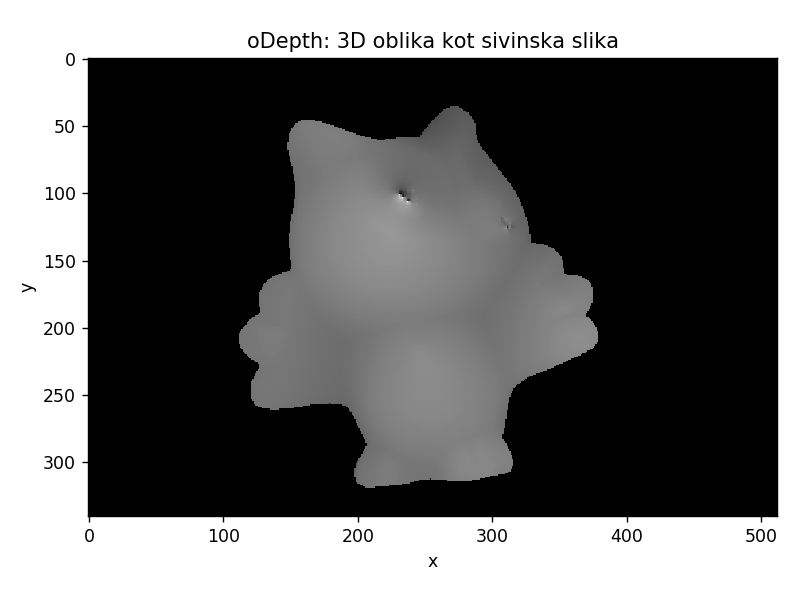

<IPython.core.display.Javascript object>


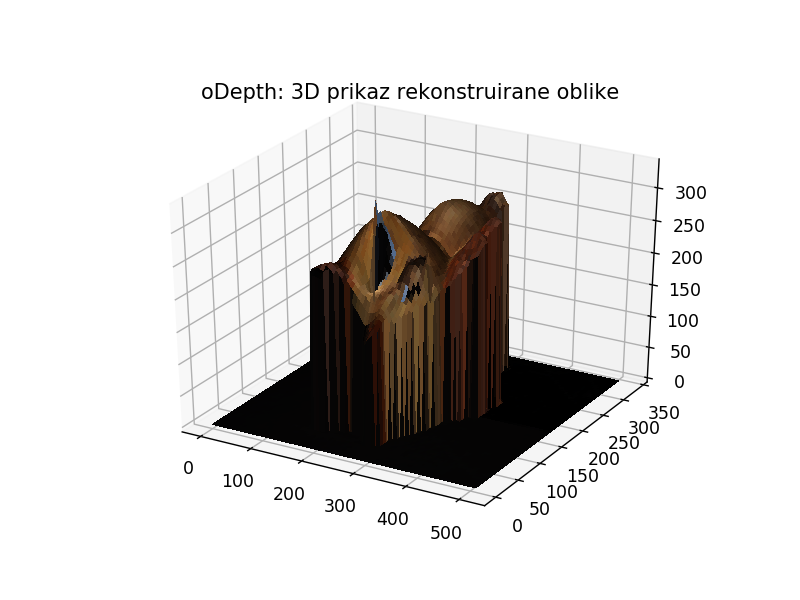

Text(0.5, 0.92, 'oDepth: 3D prikaz rekonstruirane oblike')

In [12]:
# Test funkcije
# rekonstruiraj povrsino
from mpl_toolkits.mplot3d import Axes3D
import time
ts = time.clock()
oDepth = computeDepthLinSys(oNormals, iMask)
print('elapsed time: ', 1000.0*(time.clock()-ts), ' ms')    
# prikazi kot globinsko sliko
rvlib.showImage(oDepth, 'oDepth: 3D oblika kot sivinska slika')
# narisi v obliki povrsine in obarvano    
iImage = iImages[0]
colors = iImage.astype('float') / 255.0
X, Y = np.meshgrid(range(iImage.shape[2]), range(iImage.shape[1]))
Z = oDepth

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
s = 5 # decimacija slike za hiter izris
surf = ax.plot_surface(X[::s,::s], Y[::s,::s], Z[::s,::s], \
                       rstride=1, cstride=1, facecolors=np.transpose(colors[:,::s,::s],[1,2,0]),
                       linewidth=0, antialiased=False)
plt.title('oDepth: 3D prikaz rekonstruirane oblike')  

## Dodatne naloge
Dodatne naloge naj služijo za poglobitev spretnosti programiranja, boljšemu razumevanju snovi in vsebine vaje in spoznavanju dodatnih načinov za obdelavo in analizo slik. Opravljanje dodatnih nalog je neobvezno, vendar pa priporočljivo, saj je na nek način to priprava na pisni in ustni izpit.

1. Prikažite sliko normal $\tilde{\mathbf{n}}$ kot barvno sliko, pri čemer poskrbite za ustrezno pretvorbo vrednosti komponent normal na območje `[0, 255]`.

2. Popravite funkcijo `computeNormals()` tako, do bo omogočala izračun normal na površino objekta $\mathbf{n}$ iz poljubnega števila slik objekta $N$. Vhodni parameter `iImages` naj bo matrika dimezij $Y \times X \times N$ ($X, Y$ sta dimenziji 2D slike, $N$ pa število slik z različno osvetlitvijo), `iMask` binarna maska objekta z dimenzijami $Y \times X$ in `iLightDir` matrika $N \times 3$ s smermi osvetlitve, ki ustrezajo slikam v matriki `iImages`. Funkcija vrne 3D matriko nenormaliziranih normal $\tilde{\mathbf{n}}$ dimenzij $Y \times X \times 3$ v spremenljivki `oNormals`. Preizkusite delovanje funkcije z vsemi danimi vhodnimi slikami ($N = 12$) in pripadajočimi smermi osvetlitve $\mathbf{s}_j$. 

  Prikažite povprečno barvno sliko `iMeanImage` in izrišite normale v obliki vektorskega polja s funkcijo `quiver()`. Na katerem delu objekta se smeri normal izboljšajo glede na smeri normal, ki ste jih določili le s tremi slikami? Obrazložite odgovor.

3. Razširite funkcijo `computeNormals()` tako, da bo omogočala robusten izračun normal na površino objekta $\mathbf{n}$ z uteževanjem s sivinsko vrednostjo slik, tj. osnovna enačba za zapis linearnega sistema ima obliko $I_j^2 = I_j\,(\rho\,\mathbf{s}_j^{\mathrm{T}} \cdot \mathbf{n})$. Preizkusite delovanje funkcije z vsemi danimi vhodnimi slikami ($N = 12$) in pripadajočimi smermi osvetlitve $\mathbf{s}_j$. 

  Prikažite povprečno barvno sliko `iMeanImage` in izrišite normale v obliki vektorskega polja s funkcijo `quiver()`. Na katerem delu objekta se smeri normal izboljšajo glede na smeri normal, ki ste jih določiti le s tremi slikami? Obrazložite odgovor.

4. Uporabite posodobljeno funkcijo `computeNormals()` za rekonstrukcijo 3D površine objekta z vsemi vhodnimi slikami ($N = 12$) in določite sliko globine $z(x, y)$ s funkcijo `computeDepthLinSys()`. Prikažite rekonstruirano 3D površino s funkcijo in jo obarvajte glede na povprečno barvno sliko `iMeanImage`.

![Primer rekonstrukcije](images/RV_9_SLO_PrimerRekonstrukcije.png)